<a href="https://colab.research.google.com/github/Angsumi/GPT_VISION_FOR_Animal_Classification/blob/main/Final_GPT_Vision_plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from wordcloud import WordCloud
import seaborn as sns


In [2]:
# Load Excel sheets into dataframes

xls = pd.ExcelFile('/content/Animal List2.xlsx')
input_df = xls.parse('Input')
output_df = xls.parse('Output')


In [3]:
# Data Cleaning Function

def clean_dataframe(df):
    df.columns = [col.capitalize().strip() for col in df.columns]
    for col in df.columns:
        if df[col].dtype == 'object':
            if col == 'Species':
                df[col] = df[col].str.split().str[1].str.capitalize().fillna(df[col].str.split().str[0].str.capitalize())
            else:
                df[col] = df[col].str.split().str[0].str.capitalize().str.strip()
    return df

input_df_cleaned = clean_dataframe(input_df.copy())
output_df_cleaned = clean_dataframe(output_df.copy())


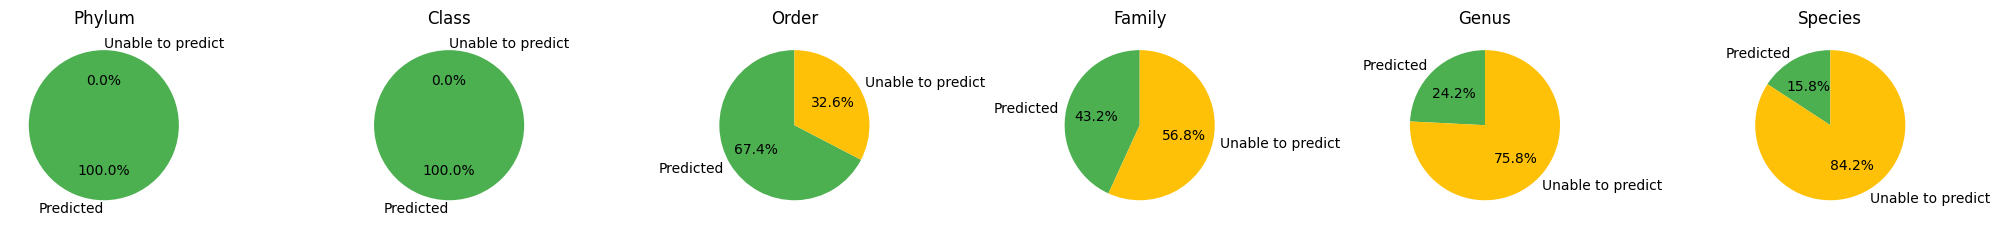

In [4]:
# Pie Diagrams for Empty Predictions

fig, axes = plt.subplots(1, output_df_cleaned.shape[1]-1, figsize=(20, 4))
for idx, col in enumerate(output_df_cleaned.columns[1:]):
    counts = ["Predicted", "Unable to predict"]
    values = [output_df_cleaned[col].notna().sum(), output_df_cleaned[col].isna().sum()]
    axes[idx].pie(values, labels=counts, autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#FFC107'])
    axes[idx].set_title(col)
plt.tight_layout()
plt.show()


In [5]:
# Accuracy Calculation

accuracies = {}
for col in input_df_cleaned.columns[1:]:
    correct_predictions = (input_df_cleaned[col] == output_df_cleaned[col]).sum()
    total_entries = input_df_cleaned.shape[0]
    accuracy = correct_predictions / total_entries
    accuracies[col] = accuracy
accuracies


{'Phylum': 0.7894736842105263,
 'Class': 0.6105263157894737,
 'Order': 0.4,
 'Family': 0.2631578947368421,
 'Genus': 0.2,
 'Species': 0.11578947368421053}

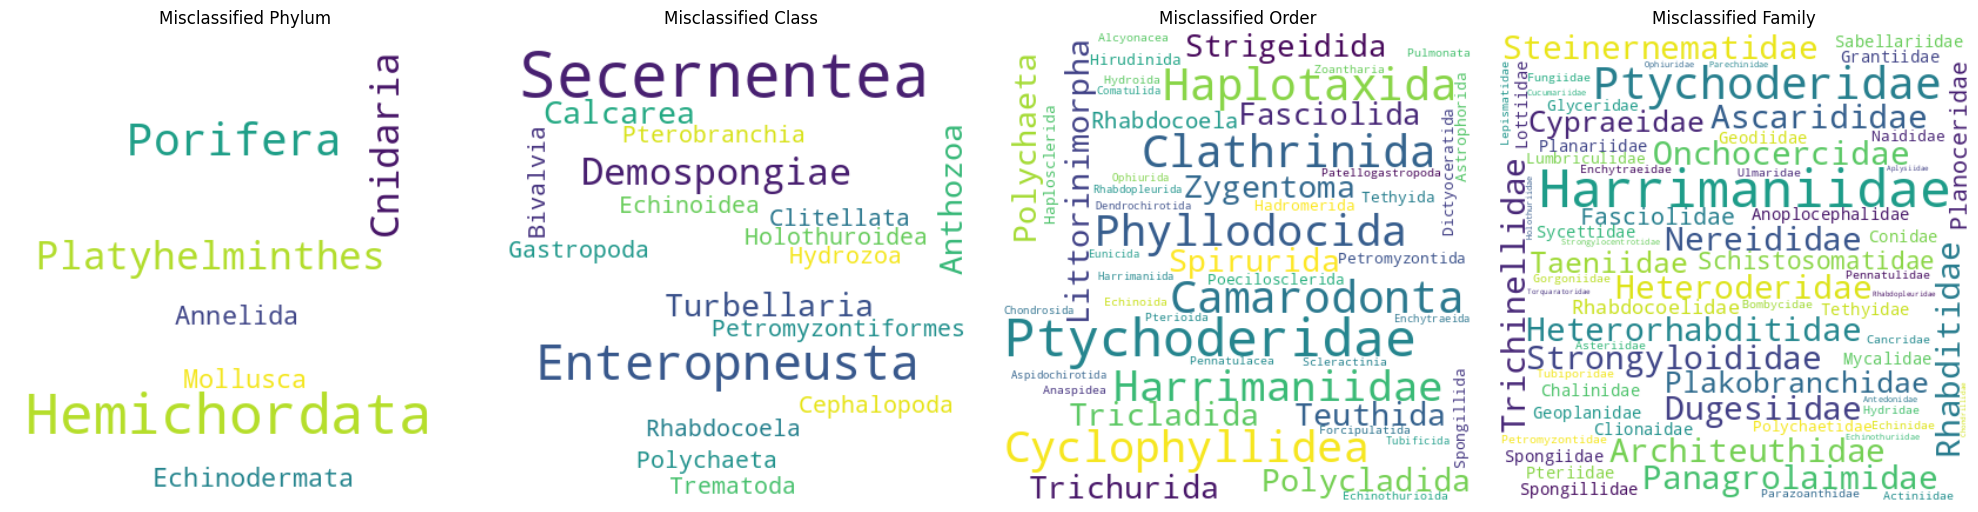

In [6]:
# Word Cloud for Misclassifications

def get_misclassified_terms(input_df, output_df, rank):
    misclassified = input_df[input_df[rank] != output_df[rank]]
    return misclassified[rank].value_counts().to_dict()

ranks = ['Phylum', 'Class', 'Order', 'Family']
fig, axes = plt.subplots(1, len(ranks), figsize=(20, 5))
for idx, rank in enumerate(ranks):
    misclassified_terms = get_misclassified_terms(input_df_cleaned, output_df_cleaned, rank)
    wc = WordCloud(background_color='white', width=400, height=400).generate_from_frequencies(misclassified_terms)
    axes[idx].imshow(wc, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(f'Misclassified {rank}')
plt.tight_layout()
plt.show()


In [7]:
# Precision, Recall, and F1-Score Calculation

precision_list = []
recall_list = []
f1_list = []
accuracy_list = []

for col in input_df_cleaned.columns[1:]:
    mask = input_df_cleaned[col].notna() & output_df_cleaned[col].notna()
    y_true = input_df_cleaned[mask][col]
    y_pred = output_df_cleaned[mask][col]

    precision_list.append(precision_score(y_true, y_pred, average='weighted'))
    recall_list.append(recall_score(y_true, y_pred, average='weighted'))
    f1_list.append(f1_score(y_true, y_pred, average='weighted'))
    accuracy_list.append((y_true == y_pred).mean())

metrics_df = pd.DataFrame({
    'Classification Level': input_df_cleaned.columns[1:],
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1-Score': f1_list
})
metrics_df


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

,Classification Level,Accuracy,Precision,Recall,F1-Score
0,Phylum,0.789474,0.776321,0.789474,0.766968
1,Class,0.610526,0.615815,0.610526,0.595321
2,Order,0.593750,0.554688,0.593750,0.567708
3,Family,0.609756,0.579268,0.609756,0.586992
4,Genus,0.826087,0.782609,0.826087,0.797101
5,Species,0.733333,0.733333,0.733333,0.733333


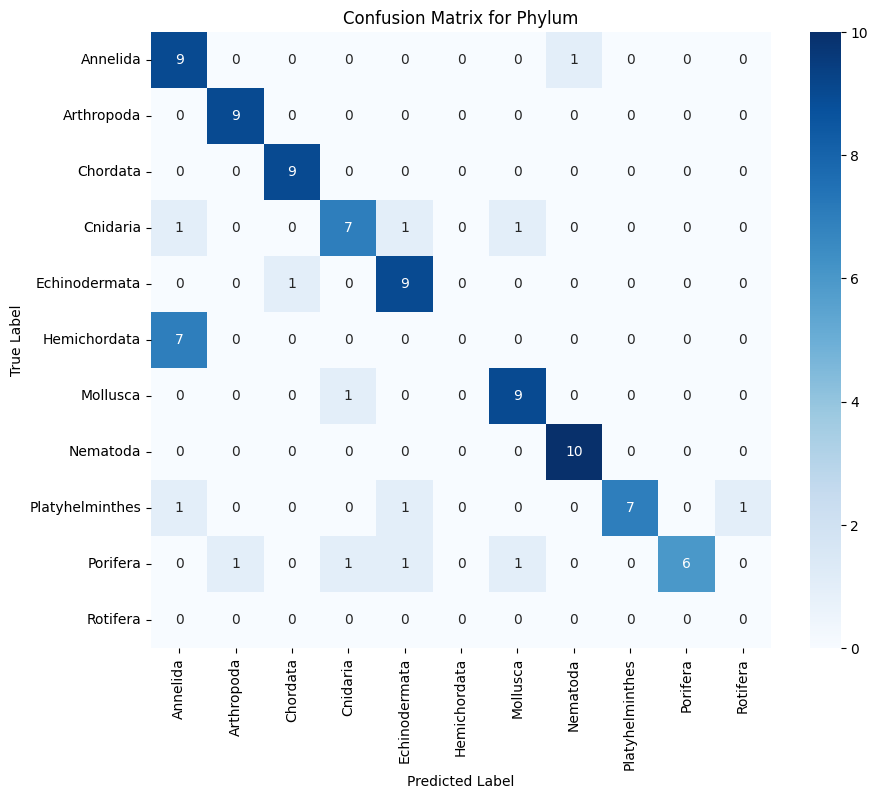

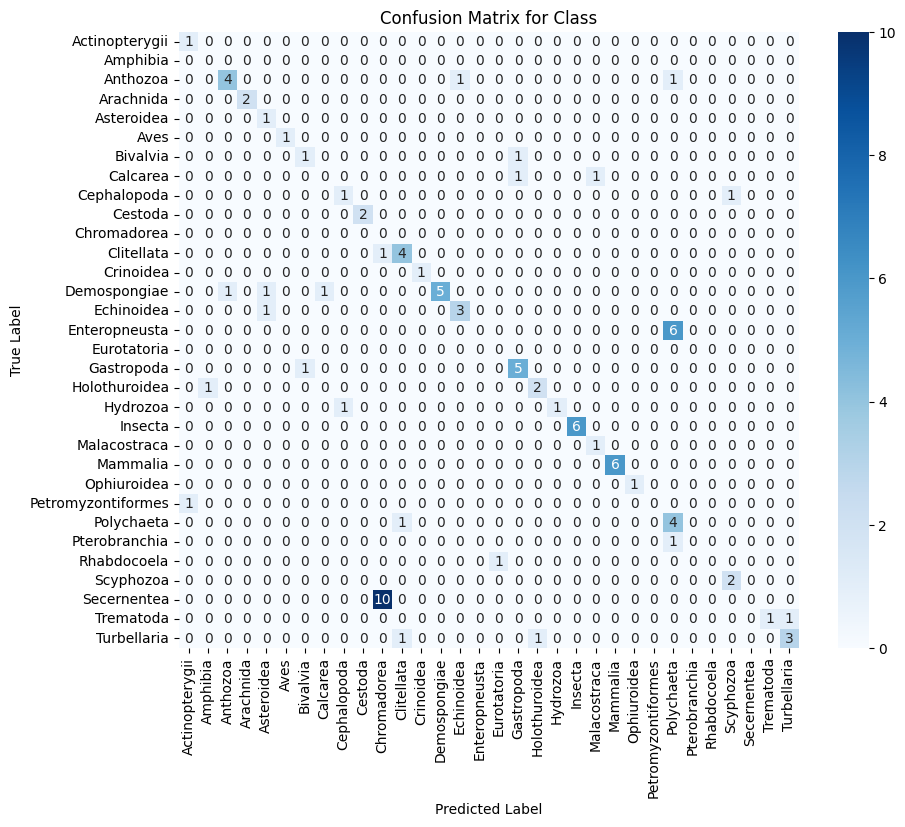

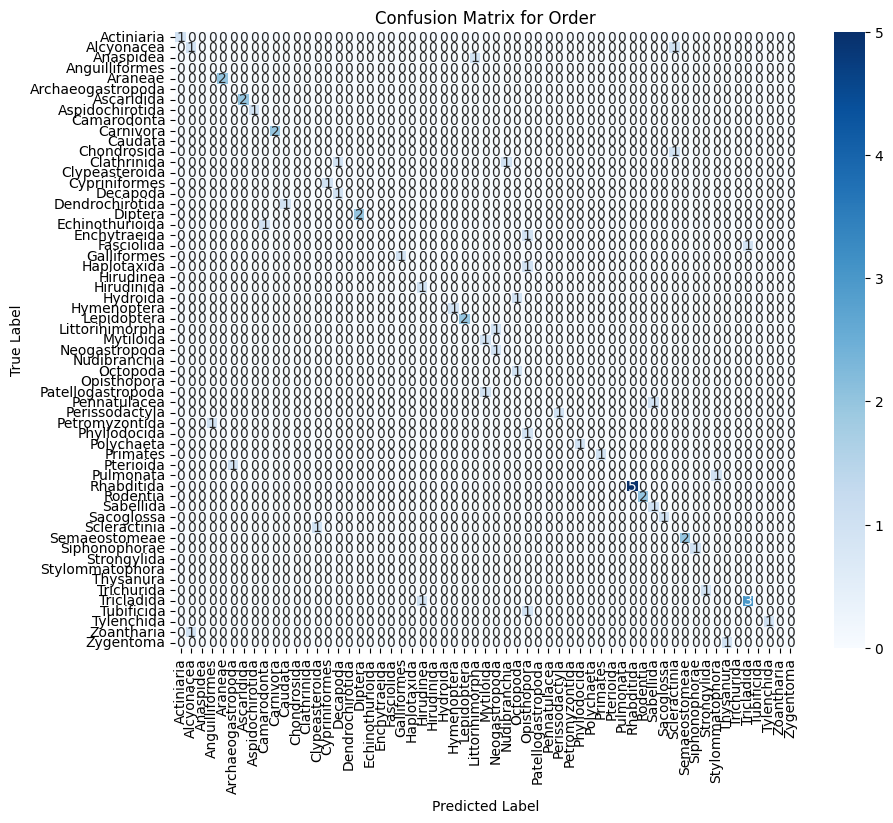

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Function to plot confusion matrix for a given rank
def plot_confusion_matrix(rank, input_df_cleaned, output_df_cleaned):
    # Filter out rows with NaN values in the considered rank for both input and output dataframes
    mask = input_df_cleaned[rank].notna() & output_df_cleaned[rank].notna()
    y_true = input_df_cleaned[mask][rank]
    y_pred = output_df_cleaned[mask][rank]

    # Compute confusion matrix
    labels = sorted(list(set(y_true).union(set(y_pred))))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_title(f'Confusion Matrix for {rank}')
    plt.show()

# Plot confusion matrices for 'Phylum', 'Class', and 'Order'
for rank in ['Phylum', 'Class', 'Order']:
    plot_confusion_matrix(rank, input_df_cleaned, output_df_cleaned)


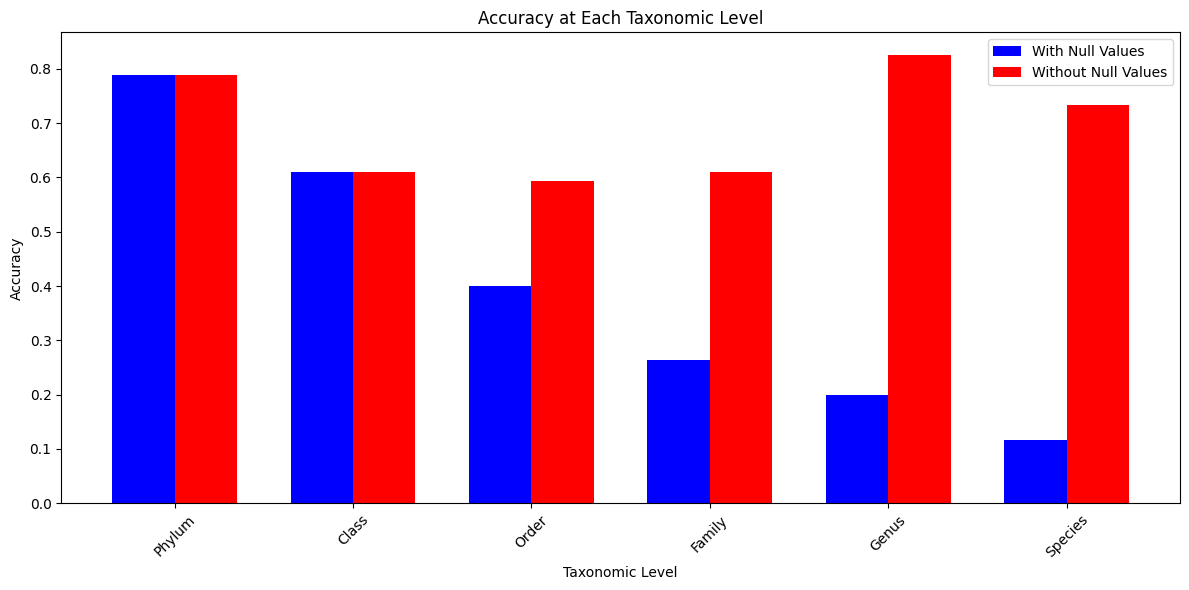

In [9]:
# Calculate accuracy for each taxonomic level considering and not considering null values
accuracies_with_null = []
accuracies_without_null = []

columns = output_df_cleaned.columns[1:]

for col in columns:
    total_values = output_df_cleaned.shape[0]

    # Correct predictions (both dataframes have the same non-null value)
    correct_predictions = (input_df_cleaned[col] == output_df_cleaned[col]).sum()

    # Not considering null values: only consider rows where both dataframes have non-null values
    not_null_rows = (input_df_cleaned[col].notna() & output_df_cleaned[col].notna()).sum()

    # Calculate accuracies
    accuracy_with_null = correct_predictions / total_values
    accuracy_without_null = correct_predictions / not_null_rows if not_null_rows != 0 else 0

    accuracies_with_null.append(accuracy_with_null)
    accuracies_without_null.append(accuracy_without_null)

# Plotting the accuracies
fig, ax = plt.subplots(figsize=(12, 6))

# Bar positions
bar_width = 0.35
index = range(len(columns))

bar1 = ax.bar(index, accuracies_with_null, bar_width, label='With Null Values', color='b')
bar2 = ax.bar([i + bar_width for i in index], accuracies_without_null, bar_width, label='Without Null Values', color='r')

# Labeling the plot
ax.set_xlabel('Taxonomic Level')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy at Each Taxonomic Level')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(columns, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


<ipython-input-15-ca234e9a7ea5>:31: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


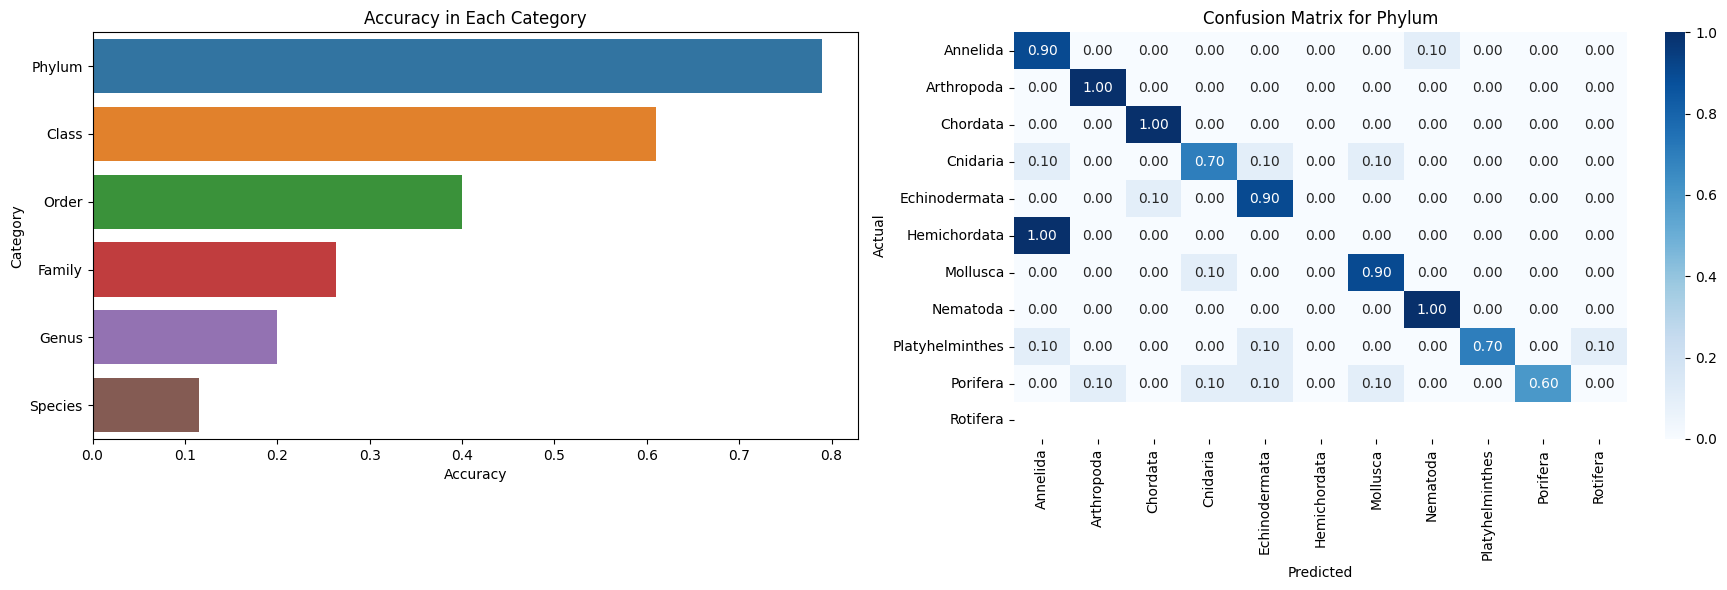

{'Phylum': 0.7894736842105263,
 'Class': 0.6105263157894737,
 'Order': 0.4,
 'Family': 0.2631578947368421,
 'Genus': 0.2,
 'Species': 0.11578947368421053}

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate accuracy treating NaN as a separate category
def calculate_accuracy(input_series, output_series):
    # Replace NaN with a string 'NaN' to treat as a separate category
    input_series_filled = input_series.fillna('NaN')
    output_series_filled = output_series.fillna('NaN')
    return accuracy_score(input_series_filled, output_series_filled)

# Assuming input_df_cleaned and output_df_cleaned are the cleaned input and output dataframes
categories = input_df_cleaned.columns.drop('Serial number')

# Calculate the accuracy for each category except 'Serial number'
accuracy_scores = {category: calculate_accuracy(input_df_cleaned[category], output_df_cleaned[category])
                   for category in categories}

# Create the confusion matrix for the 'Phylum' category again, treating NaN as a separate category
phylum_labels = np.unique(input_df_cleaned['Phylum'].fillna('NaN').tolist() +
                          output_df_cleaned['Phylum'].fillna('NaN').tolist())
conf_matrix = confusion_matrix(
    input_df_cleaned['Phylum'].fillna('NaN'),
    output_df_cleaned['Phylum'].fillna('NaN'),
    labels=phylum_labels
)

# Normalize confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar plot for accuracy in all categories
sns.barplot(x=list(accuracy_scores.values()), y=list(accuracy_scores.keys()), ax=axes[0])
axes[0].set_title('Accuracy in Each Category')
axes[0].set_xlabel('Accuracy')
axes[0].set_ylabel('Category')

# Confusion matrix for 'Phylum'
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", ax=axes[1],
            cmap='Blues', xticklabels=phylum_labels, yticklabels=phylum_labels)
axes[1].set_title('Confusion Matrix for Phylum')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Return the accuracy scores for reference
accuracy_scores


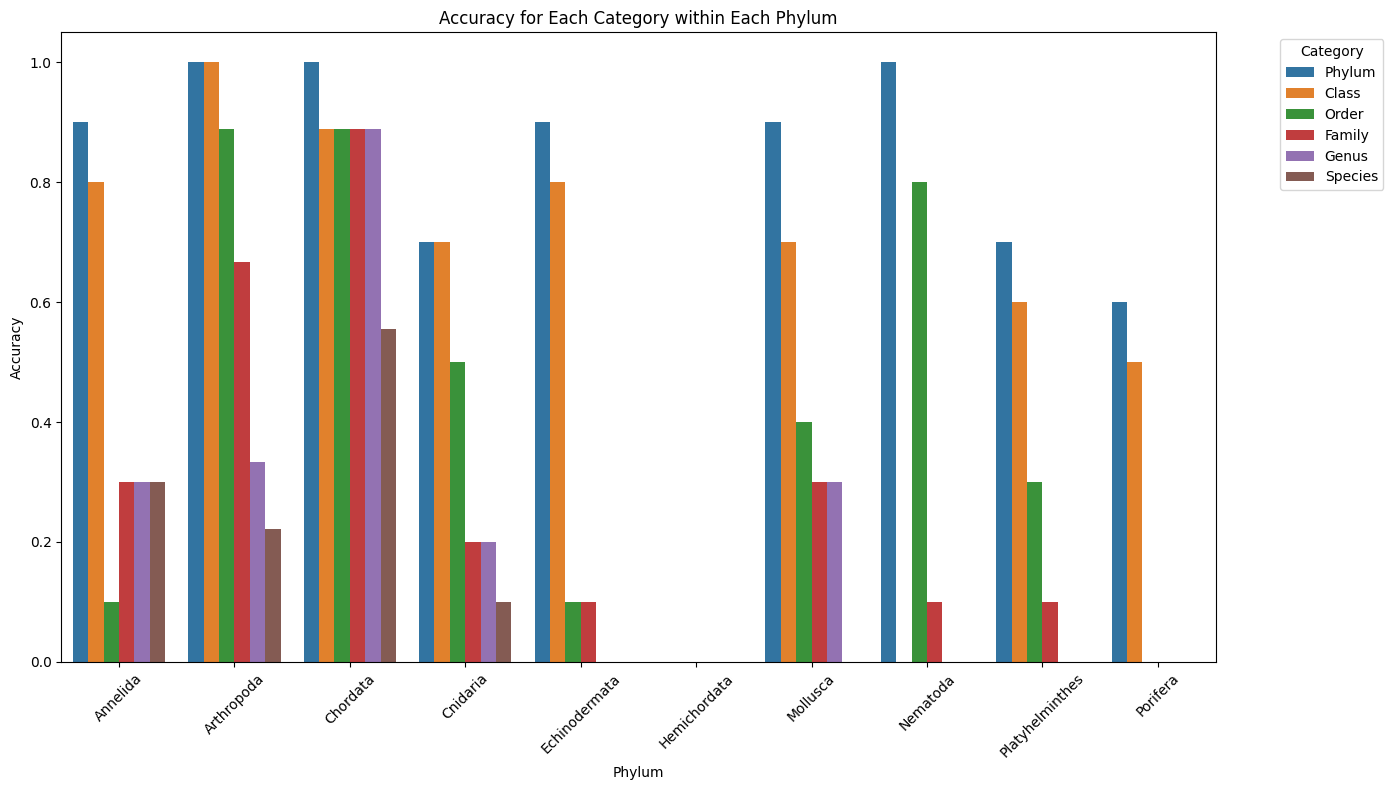

In [17]:
# Re-define the function to calculate category-wise accuracy for a given phylum
def calculate_phylum_accuracy(phylum, input_df, output_df, categories):
    # Merge the input and output dataframes on 'Serial number' to ensure matching entries
    merged_df = pd.merge(input_df, output_df, on='Serial number', suffixes=('_input', '_output'))

    # Filter the merged dataframe for the current phylum
    phylum_data = merged_df[merged_df['Phylum_input'] == phylum]

    # Calculate the accuracy for each category
    phylum_accuracy = {
        category: calculate_accuracy(
            phylum_data[f'{category}_input'],
            phylum_data[f'{category}_output']
        ) for category in categories
    }

    return phylum_accuracy

# Now we'll use the provided dataframe names 'input_df_cleaned' and 'output_df_cleaned'
categories = input_df_cleaned.columns.drop('Serial number')

# Calculate the accuracies for each category within each phylum
phylum_accuracies = {
    phylum: calculate_phylum_accuracy(phylum, input_df_cleaned, output_df_cleaned, categories)
    for phylum in input_df_cleaned['Phylum'].unique()
}

# Convert the dictionary of phylum accuracies to a long-form dataframe for plotting
accuracy_data = []

# Iterate over each phylum and its accuracy dictionary
for phylum, accuracies in phylum_accuracies.items():
    for category, accuracy in accuracies.items():
        accuracy_data.append({
            'Phylum': phylum,
            'Category': category,
            'Accuracy': accuracy
        })

# Create a dataframe
accuracy_df = pd.DataFrame(accuracy_data)

# Plot the accuracies in a single graph
plt.figure(figsize=(14, 8))
sns.barplot(x='Phylum', y='Accuracy', hue='Category', data=accuracy_df)
plt.title('Accuracy for Each Category within Each Phylum')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.xlabel('Phylum')
plt.ylabel('Accuracy')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.tight_layout()
plt.show()
